# ATP Tennis Data - Player Matchup (Raw)

We will add the following columns to our data for each player:

* matchup wins
* matchup losses
* matchup sets won
* matchup games won

### Results that did the best from Decision Tree Classifier with player diff + one hot encoded categorial features:


# Summary of Results





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import re
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-matchup_raw"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [3]:
def filter_features(data: pd.DataFrame):
    # drop all history columns
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all matchup columns that doesn't have percentage or diff
    matchup_columns = [col for col in data.columns if re.search('matchup.+(percentage|diff)', col)]
    data = data.drop(matchup_columns, axis=1)

    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)



    print(f'After: data.shape {data.shape}')
    return data




Before: data.shape (44429, 5299)
After: data.shape (44429, 5265)
Before: data.shape (14810, 5299)
After: data.shape (14810, 5265)


In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = filter_features)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

These are the columns that we kept

In [4]:
[col for col in X_train.columns if re.search('matchup', col)]

['p1_matchup_games',
 'p1_matchup_losses',
 'p1_matchup_sets',
 'p1_matchup_wins',
 'p2_matchup_games',
 'p2_matchup_losses',
 'p2_matchup_sets',
 'p2_matchup_wins']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.662120189061445

ROC/AUC Score: 0.6621218920589875
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.66      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4891  2490
Win   2514  4915


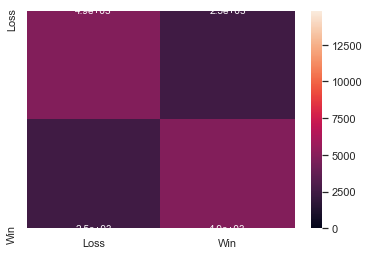

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_knn = knn.predict()

Model Score: 0.6103308575286969

ROC/AUC Score: 0.6103405514396878
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4527  2854
Win   2917  4512


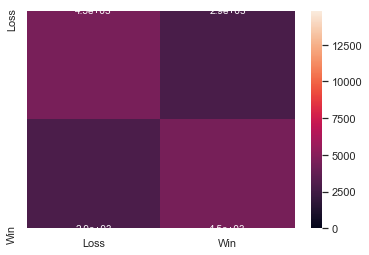

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_dt = dt.predict()

Model Score: 0.6047265361242404

ROC/AUC Score: 0.6047206332032844
              precision    recall  f1-score   support

        Loss       0.60      0.60      0.60      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.60     14810
   macro avg       0.60      0.60      0.60     14810
weighted avg       0.60      0.60      0.60     14810

      Loss   Win
Loss  4450  2931
Win   2923  4506


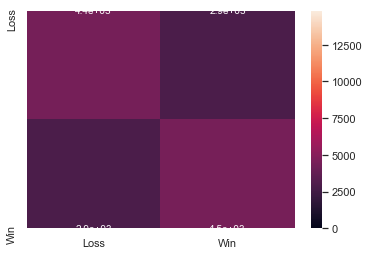

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6414584740040513

ROC/AUC Score: 0.6417103180943442
              precision    recall  f1-score   support

        Loss       0.62      0.72      0.67      7381
         Win       0.67      0.56      0.61      7429

    accuracy                           0.64     14810
   macro avg       0.65      0.64      0.64     14810
weighted avg       0.65      0.64      0.64     14810

      Loss   Win
Loss  5310  2071
Win   3239  4190


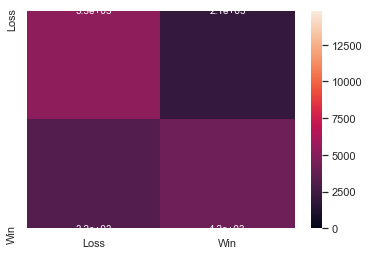

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3670            9.24m
         2           1.3505            9.26m
         3           1.3357            9.18m
         4           1.3238            8.99m
         5           1.3131            8.80m
         6           1.3044            8.67m
         7           1.2958            8.53m
         8           1.2890            8.43m
         9           1.2824            8.31m
        10           1.2770            8.19m
        20           1.2379            7.37m
        30           1.2102            6.48m
        40           1.1907            5.50m
        50           1.1803            4.56m
        60           1.1719            3.65m
        70           1.1671            2.72m
        80           1.1641            1.80m


Model Score: 0.6814314652261985

ROC/AUC Score: 0.6814233042316926
              precision    recall  f1-score   support

        Loss       0.68      0.68      0.68      7381
         Win       0.68      0.68      0.68      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810

      Loss   Win
Loss  5011  2370
Win   2348  5081


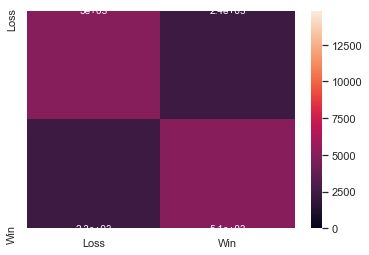

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_ab = ab.predict()

Model Score: 0.6643484132343012

ROC/AUC Score: 0.6643661152884984
              precision    recall  f1-score   support

        Loss       0.66      0.67      0.67      7381
         Win       0.67      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4944  2437
Win   2534  4895


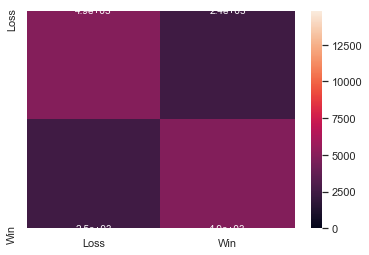

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results

In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
78,LogisticRegression,ohe-matchup_raw,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.662120,0.662122,"{""0"": {""0"": 4891, ""1"": 2514}, ""1"": {""0"": 2490,...","{""Loss"": {""precision"": 0.6604996623902768, ""re...",../models/logisticregression-1998-2018-ohe-mat...,0.0,0.0,0.0
79,KNeighborsClassifier,ohe-matchup_raw,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.610331,0.610341,"{""0"": {""0"": 4527, ""1"": 2917}, ""1"": {""0"": 2854,...","{""Loss"": {""precision"": 0.6081407845244492, ""re...",../models/kneighborsclassifier-1998-2018-ohe-m...,0.0,0.0,0.0
80,DecisionTreeClassifier,ohe-matchup_raw,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.604727,0.604721,"{""0"": {""0"": 4450, ""1"": 2923}, ""1"": {""0"": 2931,...","{""Loss"": {""precision"": 0.603553506035535, ""rec...",../models/decisiontreeclassifier-1998-2018-ohe...,0.0,0.0,0.0
81,RandomForestClassifier,ohe-matchup_raw,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.641458,0.641710,"{""0"": {""0"": 5310, ""1"": 3239}, ""1"": {""0"": 2071,...","{""Loss"": {""precision"": 0.6211252778102702, ""re...",../models/randomforestclassifier-1998-2018-ohe...,0.0,0.0,0.0
82,GradientBoostingClassifier,ohe-matchup_raw,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.681431,0.681423,"{""0"": {""0"": 5011, ""1"": 2348}, ""1"": {""0"": 2370,...","{""Loss"": {""precision"": 0.6809349096344612, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,7.0,7.0
83,AdaBoostClassifier,ohe-matchup_raw,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.664348,0.664366,"{""0"": {""0"": 4944, ""1"": 2534}, ""1"": {""0"": 2437,...","{""Loss"": {""precision"": 0.6611393420700722, ""re...",../models/adaboostclassifier-1998-2018-ohe-mat...,0.0,1.0,1.0


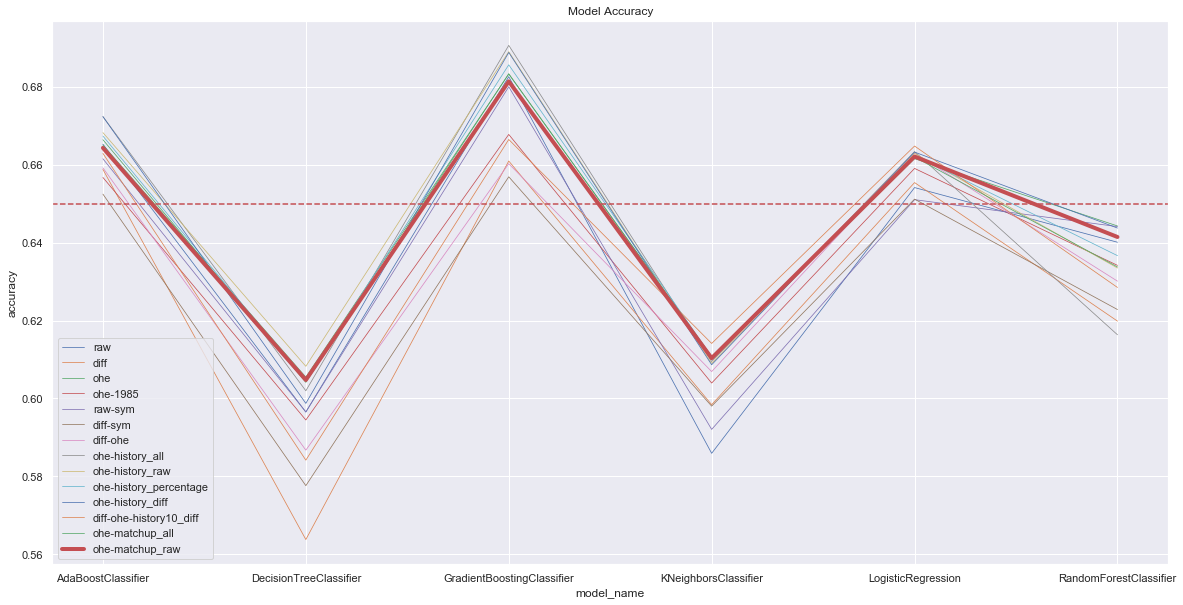

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


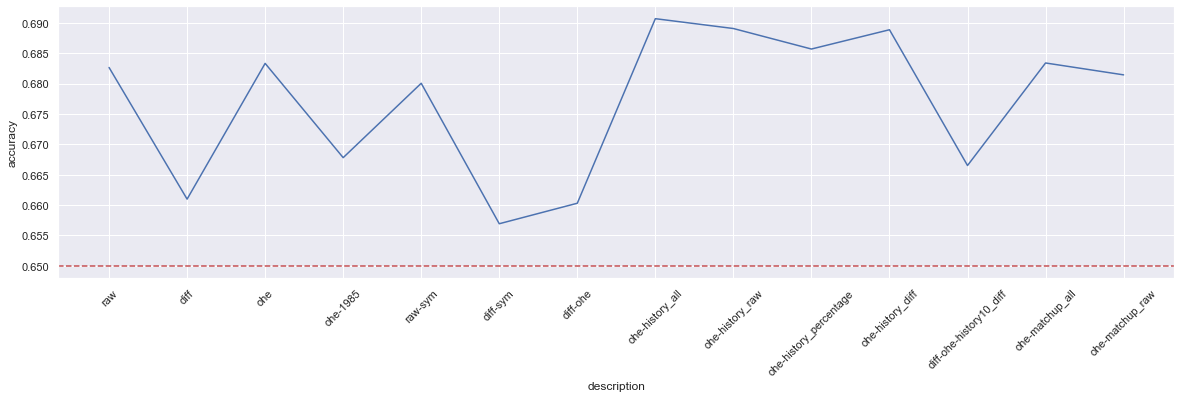

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

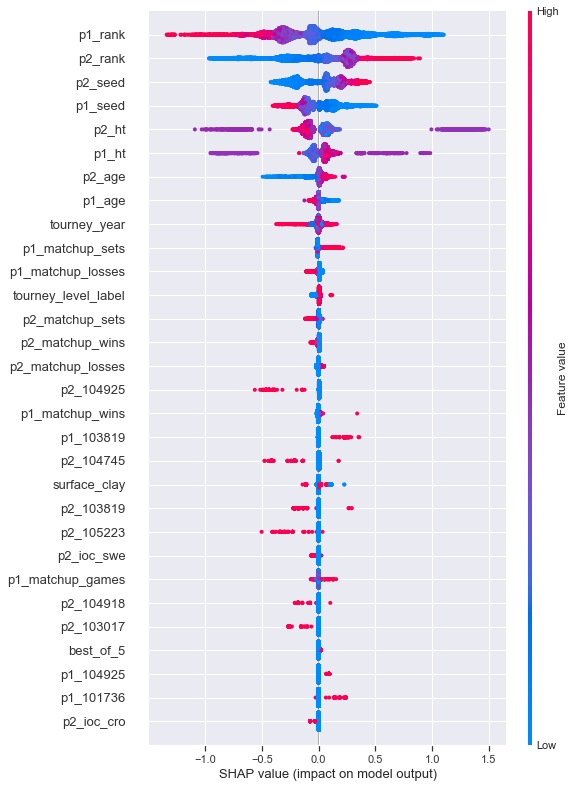

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

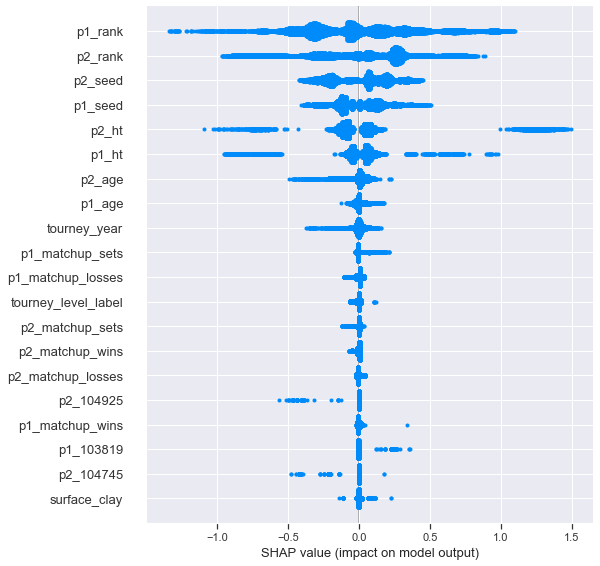

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-21 03:58
